In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
def read_dataset(filename="../data/updated_dataset.json"):
    with open(filename, "r") as f:
        return json.load(f)
dataset = read_dataset()

In [4]:
# Load the data into a DataFrame
df = pd.DataFrame.from_dict(dataset, orient='index')

# Create an empty list to store the transformed rows
transformed_rows = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    interests = row['interests']
    posts = row['posts']

    # Iterate over each post in the 'posts' dictionary
    for post_id, post_content in posts.items():
        caption = post_content.get('caption', None)
        if caption is None:
            continue
        # Create a new row with the post details
        new_row = {
            'username': index,
            'id': post_id,
            'caption': caption,
            'interests': interests
        }
        transformed_rows.append(new_row)

# Create a new dataframe from the transformed rows and infer the schema types
df = pd.DataFrame(transformed_rows, dtype='string')

# Print the resulting dataframe randomly
df.sample(7)

,username,id,caption,interests
798,adamsenatori,17929928024643983,Inter and oil. #painting #footballislife,"Photography, Travel, Nature"
25459,laurasykora,18229412872084048,"Even after a decade on here, I’m still more co...",Fitness and wellness
29267,bertavallo,17892172189461593,Illustration for Bernard Shaw’s Widowers’ Hous...,"Arts and music, Painting, Books"
31176,leiartista,17842284202804896,Little plants on wood panel :) please dm me if...,Painting
1801,macenzo,17849400094196657,>>>>>>>> . #Brussels #SeeMyCity #Architecture,"Photography, Architecture, Travel, Design"
17256,geometryclub,18008602498113911,"Rome, Italy — Palazzo della Civiltà Italiana, ...","Architecture,Design"
2225,Bythebrush,17862740602068137,at the barn door,"Photography, Painting, Drawing"


In [5]:
interest_mapping = {
    'business': 'Business and Industry',
    'books': 'Entertainment',
    'entertainment': 'Entertainment',
    'pets': 'Pets',
    'family and relationships': 'Family and Relationships',
    'home and garden': 'Family and Relationships',
    'shopping and fashion': 'Fashion and Style',
    'travel': 'Travel and Adventure',
    'adventure': 'Travel and Adventure',
    'outdoor recreation': 'Travel and Adventure',
    'nature': 'Travel and Adventure',
    'food and drink': 'Food and Dining',
    'sports': 'Sports and Fitness',
    'fitness and wellness': 'Sports and Fitness',
    'wellness': 'Sports and Fitness',
    'technology': 'Technology and Gadgets',
    'vehicles': 'Technology and Gadgets',
    'online': 'Technology and Gadgets',
    'design': 'Arts and Culture',
    'architecture': 'Arts and Culture',
    'photography': 'Arts and Culture',
    'sculpture': 'Arts and Culture',
    'arts and music': 'Arts and Culture',
    'music': 'Arts and Culture',
    'drawing': 'Arts and Culture',
    'news': 'News',
    'politics and social issues': 'News',
    'painting': 'Arts and Culture',
}
all_interests= [
    'Fashion and Style',
    'Food and Dining',
    'Family and Relationships',
    'Sports and Fitness',
    'Entertainment',
    'Business and Industry',
    'Travel and Adventure',
    'Arts and Culture',
    'News',
    'Pets',
    'Technology and Gadgets'
]

In [6]:
# Transform the interests column to a list of strings
new_df = df.copy()
# make username the index

new_df['interests'] = df['interests']\
    .apply(lambda x: x.split(','))\
    .apply(lambda x: list(map(lambda y: y.strip().lower(), x)))\
    .apply(lambda x: list(map(lambda y: interest_mapping[y], x)))\
    .apply(lambda x: list(set(x)))


# Clean the caption column by removing the hashtags and mentions and converting to lowercase, and remove all special characters and emojis
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


new_df['caption'] = new_df['caption'].apply(clean_text)

# Set the value of the interest column to 1 if the user has that interest
for interest in all_interests:
    new_df[interest] = new_df['interests'].apply(lambda x: 1 if interest in x else 0).astype('int8')

# Drop the interests column
new_df.drop(columns=['interests'], inplace=True)

# Drop the rows with empty captions without using dropna
new_df = new_df[new_df['caption'] != '']

new_df.sample(5)

,username,id,caption,Fashion and Style,Food and Dining,Family and Relationships,Sports and Fitness,Entertainment,Business and Industry,Travel and Adventure,Arts and Culture,News,Pets,Technology and Gadgets
19602,thebibliotheque,17923696487253435,sebastian stanman youre looking goodi should p...,0,0,0,0,1,0,0,0,0,0,0
35678,nypost,17960952770374208,3yearold takes parents 550k ferarri for a spin...,0,0,0,0,0,0,0,0,1,0,0
31335,apple,17864611532871455,i am always looking for a cinematic moment wit...,0,0,0,0,0,0,0,0,0,0,1
38983,datascienceuniverse,18069196768194458,refrigerator is not a bad guess source deeplea...,0,0,0,0,0,0,0,0,0,0,1
22050,pedromcbride,17972282656878602,happy halloween one of the scariest things ive...,0,0,0,0,0,0,1,1,0,0,0


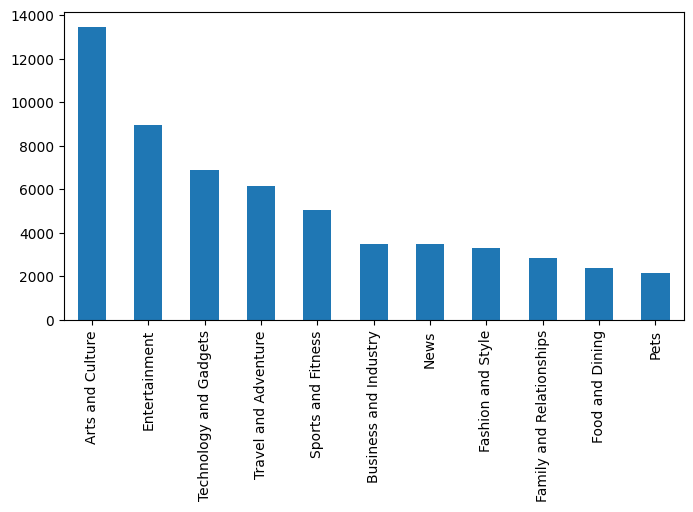

In [7]:
plt.figure(figsize=(8, 4))
new_df[all_interests].sum().sort_values(ascending=False).plot.bar()
plt.show()

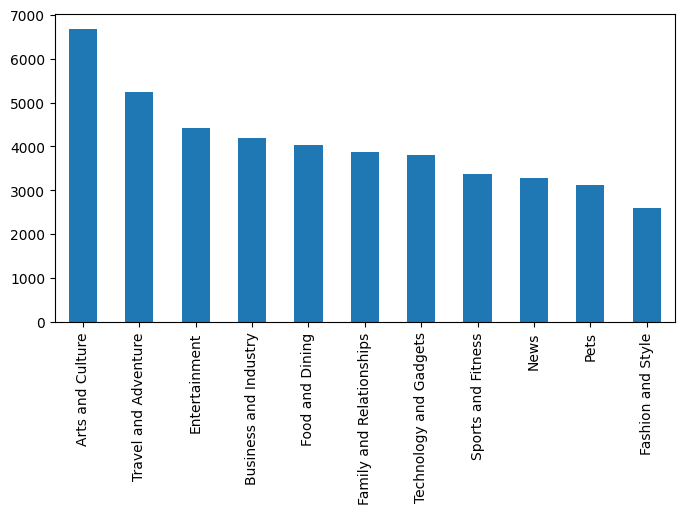

In [8]:
from sklearn.utils import resample

desired_count = new_df[all_interests].sum().min()

balanced_df = pd.DataFrame(columns=new_df.columns)

for interest in all_interests:
    df = new_df[new_df[interest] == 1]
    df = resample(df, replace=False, n_samples=desired_count)
    balanced_df = balanced_df.append(df)

new_df = balanced_df
plt.figure(figsize=(8, 4))
new_df[all_interests].sum().sort_values(ascending=False).plot.bar()
plt.show()

In [9]:
new_df.sample(7)

,username,id,caption,Fashion and Style,Food and Dining,Family and Relationships,Sports and Fitness,Entertainment,Business and Industry,Travel and Adventure,Arts and Culture,News,Pets,Technology and Gadgets
6162,this_girl_is_a_squirrel,18128155462036075,everyday we choose love sade by your side,0,1,0,0,0,0,0,0,0,1,0
6834,masai_mara_guide,17889922861764237,ele showing off some awesome skills,0,0,0,0,0,0,1,0,0,1,0
3879,bhgaus,18027385063473660,tonight dr harry helps richard the protective ...,0,1,1,0,0,0,1,0,0,0,0
4371,arthurparkinson_,17968552664232210,with a lovely buff orpington,0,0,1,0,0,0,0,0,0,0,0
10183,perpetualpages,17913301855980509,here are some thrillers and mysteries that i l...,0,0,1,0,1,0,0,0,0,0,0
17474,geometryclub,17846541022069986,buenos aires argentina a first from argentina ...,0,0,0,0,0,0,0,1,0,0,0
38287,carthrottle,18023967010440706,new video live tomorrow who can guess whats go...,0,0,0,0,0,0,0,0,0,0,1


In [10]:
new_df.to_csv('../data/cleaned_dataset.csv', index=False) # save the cleaned dataset to a csv file